In [22]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skimage import io, color, transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA


Preprocessing

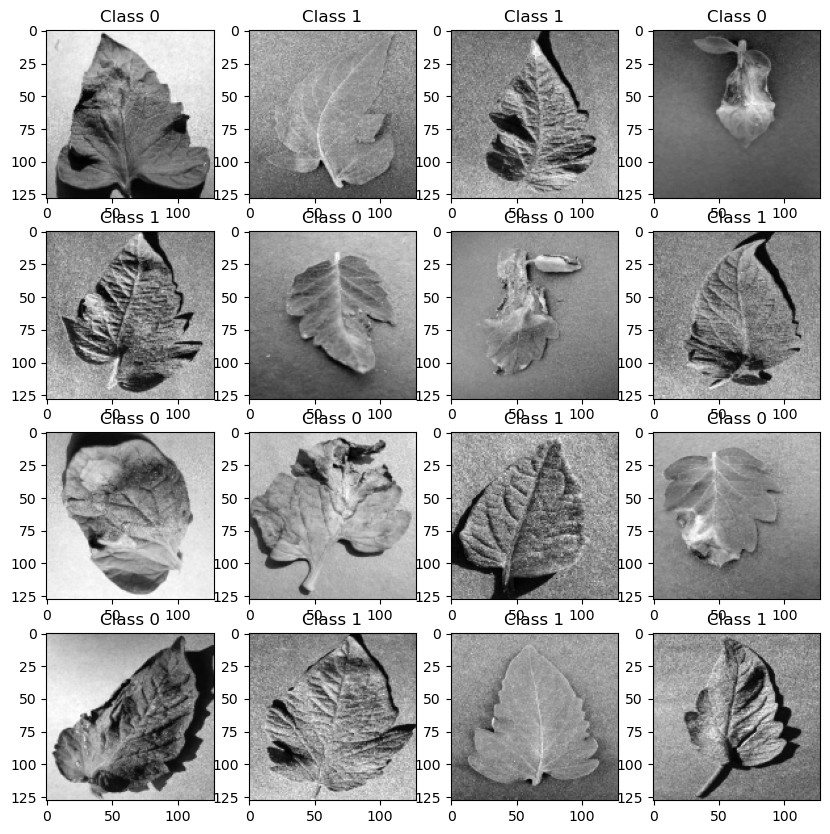

In [45]:
image_size = (128, 128)
num_classes = 2  # Update to the correct number of classes in your dataset

def load_dataset(data_dir):
    X = []
    y = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_file in os.listdir(class_dir):
            if image_file.endswith(".JPG"):
                img = io.imread(os.path.join(class_dir, image_file))
                img = transform.resize(img, image_size)
                img = color.rgb2gray(img)
                X.append(img)
                y.append(class_name)

    X = np.array(X)
    y = np.array(y)

    X = X / 255.0

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y

data_dir = r'C:\Users\HAI\Desktop\project\New folder'

X, y = load_dataset(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i].reshape(image_size), cmap='gray')
    plt.title(f'Class {y_train[i]}')
plt.show()

Data Augmentation

In [24]:

augmented_X = []
augmented_y = []

for i in range(len(X_train)):
    augmented_X.append(X_train[i])
    augmented_y.append(y_train[i])
    augmented_X.append(np.rot90(X_train[i]))
    augmented_y.append(y_train[i])
    augmented_X.append(np.fliplr(X_train[i]))
    augmented_y.append(y_train[i])

augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(augmented_X.reshape(-1, image_size[0] * image_size[1]))


Hyperparameter Tuning

In [56]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [300,400],
    'max_depth': [25,40]
} 

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid.fit(X_train_pca, augmented_y)

# Get the best hyperparameters from the grid search
best_params = grid.best_params_


Model and log loss calculation

In [58]:
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train_pca, augmented_y)

RandomForestClassifier(max_depth=25, n_estimators=400, random_state=42)

In [61]:
X_test_pca = pca.transform(X_test.reshape(-1, image_size[0] * image_size[1]))


# Calculate log loss for the model's predictions on the test set
y_score = best_model.predict_proba(X_test_pca)
log_loss_value = log_loss(y_test, y_score)

# Calculate accuracy
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

Performance metrics

In [62]:
print(f"Log Loss: {log_loss_value:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Log Loss: 0.4596
Accuracy: 89.81%


Classification report

In [51]:
class_names = [f"Class {i}" for i in range(num_classes)]
classification_rep = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.96      0.90       182
     Class 1       0.95      0.82      0.88       181

    accuracy                           0.89       363
   macro avg       0.90      0.89      0.89       363
weighted avg       0.90      0.89      0.89       363



ROC Curve

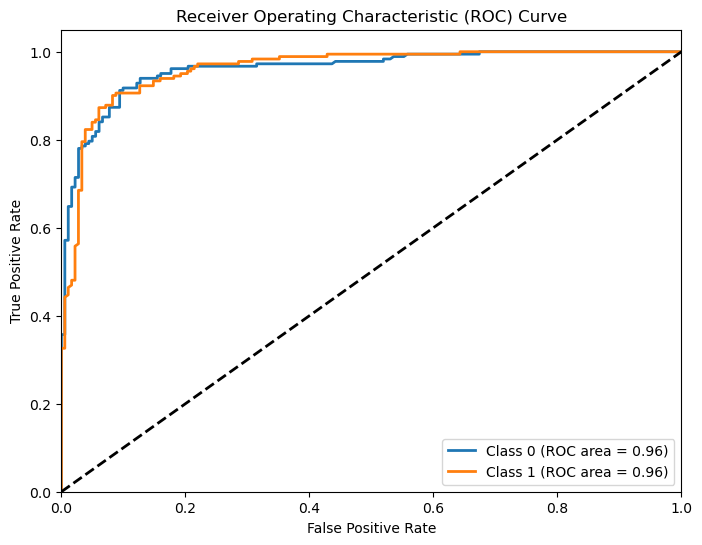

In [52]:
# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (ROC area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix

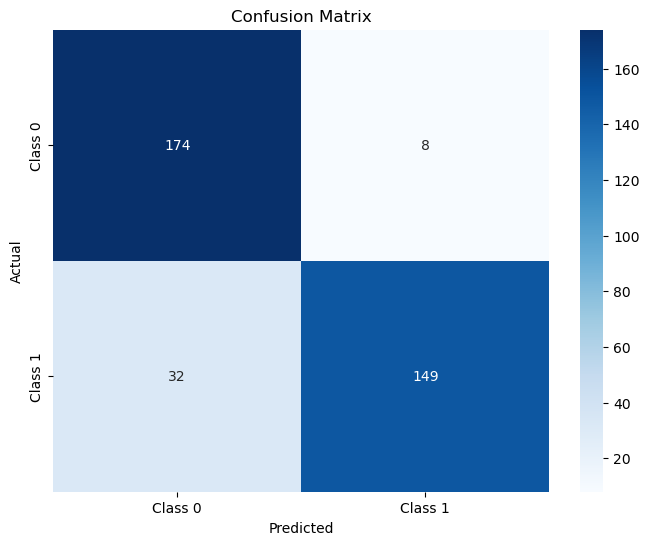

In [53]:
cm = confusion_matrix(y_test, y_pred)

# Define class names (replace with your actual class names)
class_names = ['Class 0', 'Class 1']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [59]:
best_params

{'max_depth': 25, 'n_estimators': 400}

In [40]:
import pickle